# Descriptive analysis with Linear Regression

[Global Temperature Time Series](https://datahub.io/core/global-temp#data). Data are included from the GISS Surface Temperature (GISTEMP) analysis and the global component of Climate at a Glance (GCAG). Two datasets are provided: 1) global monthly mean and 2) annual mean temperature anomalies in degrees Celsius from 1880 to the present.

## Description 

1. GISTEMP Global Land-Ocean Temperature Index:

Combined Land-Surface Air and Sea-Surface Water Temperature Anomalies [i.e. deviations from the corresponding 1951-1980 means]. Global-mean monthly […] and annual means, 1880-present, updated through most recent month.

2. Global component of Climate at a Glance (GCAG):

Global temperature anomaly data come from the Global Historical Climatology Network-Monthly (GHCN-M) data set and International Comprehensive Ocean-Atmosphere Data Set (ICOADS), which have data from 1880 to the present. These two datasets are blended into a single product to produce the combined global land and ocean temperature anomalies. The available timeseries of global-scale temperature anomalies are calculated with respect to the 20th century average […].

## Theoretical background 

- [Generalized Linear Models](http://scikit-learn.org/stable/modules/linear_model.html)
- [Linear Regression Example](http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html) 
--- 

---

In [1]:
import numpy as np
import pandas as pd
import scipy, scipy.stats
import matplotlib.pyplot as plt
from fitter import Fitter
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set()

In [2]:
data = pd.read_json("data/temperature/monthly_json.json") 

In [3]:
data.head()

,Date,Mean,Source
0,2016-12-06,0.7895,GCAG
1,2016-12-06,0.8100,GISTEMP
2,2016-11-06,0.7504,GCAG
3,2016-11-06,0.9300,GISTEMP
4,2016-10-06,0.7292,GCAG


In [4]:
data = data.pivot(index='Date', columns='Source', values='Mean')

In [5]:
data.head()

Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18
1880-04-06,-0.0499,-0.27
1880-05-06,-0.0738,-0.14


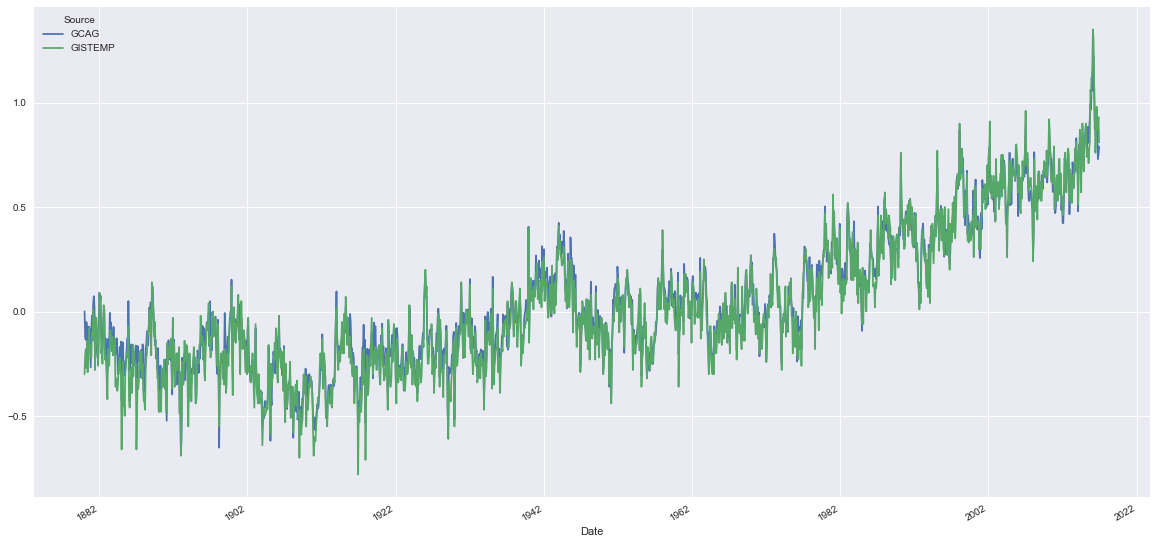

In [6]:
data.plot(figsize=(20,10))

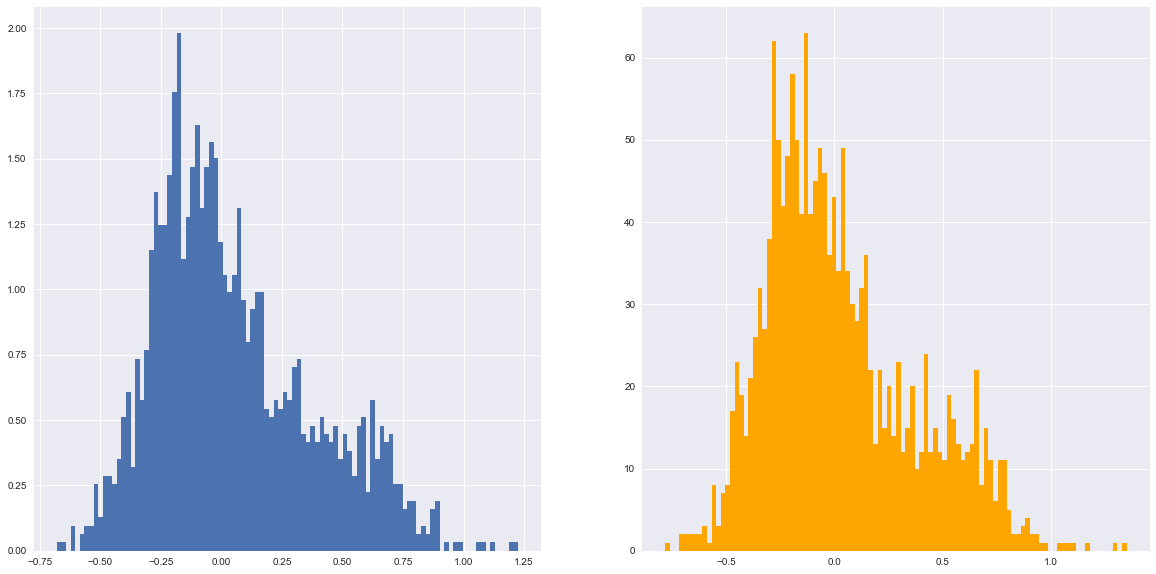

In [7]:
plt.figure(1, figsize=(20,10))

plt.subplot(1,2,1)
plt.hist(data['GCAG'], bins=100, density=True)

plt.subplot(1,2,2)
plt.hist(data['GISTEMP'], bins=100, color='orange')

plt.show()

In [8]:
data.describe()

Source,GCAG,GISTEMP
count,1644.000000,1644.000000
mean,0.048797,0.024380
std,0.326230,0.343709
min,-0.679600,-0.780000
25%,-0.190625,-0.230000
50%,-0.021650,-0.050000
75%,0.252150,0.230000
max,1.224500,1.350000


In [9]:
loc_gcag = 0.048797
scale_gcag = 0.326230
lower = scipy.stats.norm.ppf(0.01,loc_gcag,scale_gcag)
upper = scipy.stats.norm.ppf(0.99,loc_gcag,scale_gcag)
x_gcag = scipy.linspace(lower,upper,100)

y_gcag = scipy.stats.norm.pdf(x_gcag,loc_gcag,scale_gcag)

In [10]:
loc_gistemp = 0.024380
scale_gistemp = 0.343709
lower = scipy.stats.norm.ppf(0.01,loc_gistemp,scale_gistemp)
upper = scipy.stats.norm.ppf(0.99,loc_gistemp,scale_gistemp)
x_gistemp = scipy.linspace(lower,upper,100)

y_gistemp = scipy.stats.norm.pdf(x_gistemp,loc_gistemp,scale_gistemp)

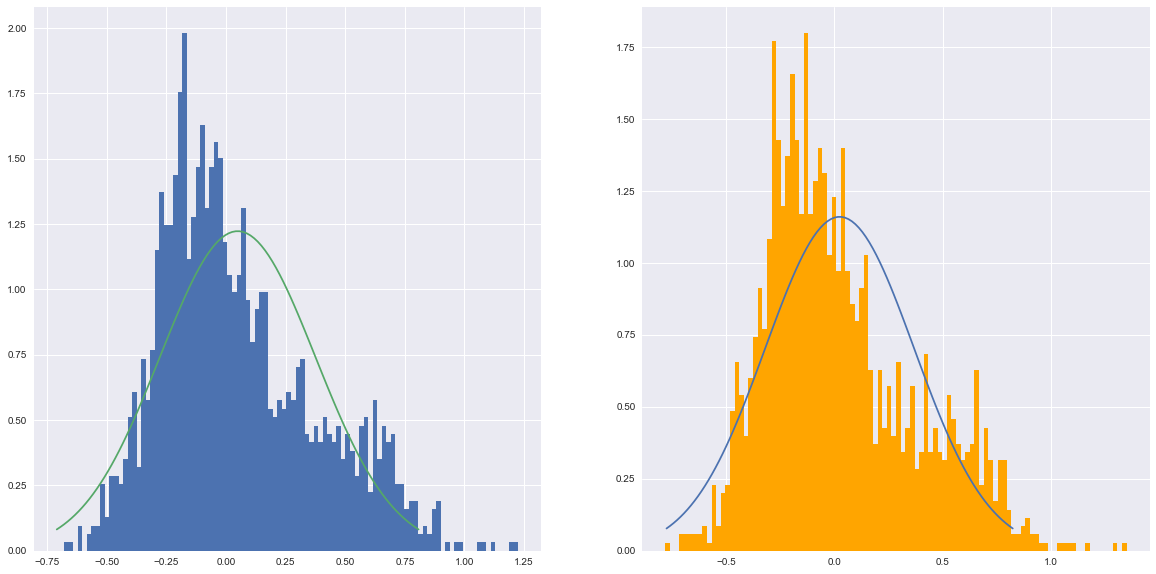

In [11]:
plt.figure(1, figsize=(20,10))

plt.subplot(1,2,1)
plt.hist(data['GCAG'], bins=100, density=True)
plt.plot(x_gcag,y_gcag)

plt.subplot(1,2,2)
plt.hist(data['GISTEMP'], bins=100, density=True, color='orange')
plt.plot(x_gistemp,y_gistemp)

plt.show()

---

Fitted exponnorm distribution with error=1.6795469686137436)


/home/user/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


,sumsquare_error
exponnorm,1.679547


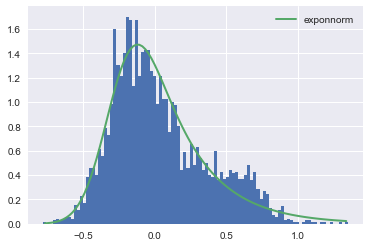

In [12]:
from fitter import Fitter
f = Fitter(data, distributions=['exponnorm'])
f.fit()
f.summary()

In [13]:
data['timestamp'] = pd.to_datetime(data.index.values).astype(np.int64)

In [14]:
data['timestamp'] = data['timestamp'] / 10**10

In [15]:
data.head()

Source,GCAG,GISTEMP,timestamp
Date,,,
1880-01-06,0.0009,-0.30,-283970880.0
1880-02-06,-0.1229,-0.21,-283703040.0
1880-03-06,-0.1357,-0.18,-283452480.0
1880-04-06,-0.0499,-0.27,-283184640.0
1880-05-06,-0.0738,-0.14,-282925440.0


In [16]:
np.array(data['timestamp'], dtype=pd.Series).reshape(-1, 1)

array([[-283970880.0],
       [-283703040.0],
       [-283452480.0],
       ...,
       [147571200.0],
       [147839040.0],
       [148098240.0]], dtype=object)

--- 
## Linear Regression 

In [17]:
# Create linear regression object
regr = linear_model.LinearRegression()

### GCAG vs. GISTEMP

In [18]:
# Train the model using the GCAG dataset 
x_train = np.array(data['timestamp'], dtype=pd.Series).reshape(-1, 1) # timeline 
y_train = data['GCAG'].values # training data 
x_test = np.array(data['timestamp'], dtype=pd.Series).reshape(-1, 1) # timeline 
y_test = data['GISTEMP'].values # test data 

regr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
# Make prediction using the test dataset
y_prediction = regr.predict(x_test)

In [20]:
# The coefficients
print("Coefficient: %.10f"
      % regr.coef_)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_prediction))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_prediction))

Coefficient: 0.0000000022
Mean squared error: 0.04
Variance score: 0.67


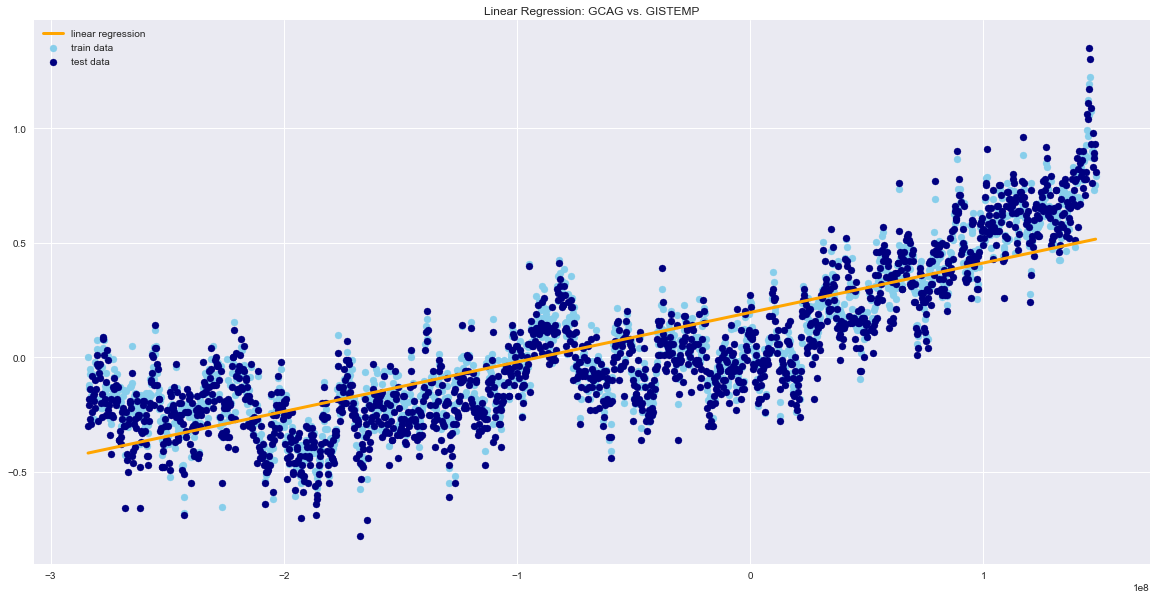

In [21]:
# Plot outputs
plt.figure(figsize=(20,10))
plt.scatter(x_train, y_train, color='skyblue', label='train data')
plt.scatter(x_test, y_test, color='navy', label='test data')
plt.plot(x_test, y_prediction, color='orange', linewidth=3, label='linear regression')

plt.axis('tight')
plt.legend()
plt.title("Linear Regression: GCAG vs. GISTEMP")

plt.show();

### Splitting dataset into training and testing subsets 

In [22]:
# Split the dataset pseudo-randomly into training and testing subsets 

"""
for details see http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
"""

x = np.array(data['timestamp'], dtype=pd.Series).reshape(-1, 1) # timeline 
y = data['GCAG'].values # dataset 

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.33, random_state=42)

regr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
# Make predictions using the training dataset
y_prediction = regr.predict(x_test)

In [24]:
# The coefficients
print("Coefficient: %.10f"
      % regr.coef_)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_prediction))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_prediction))

Coefficient: 0.0000000022
Mean squared error: 0.03
Variance score: 0.67


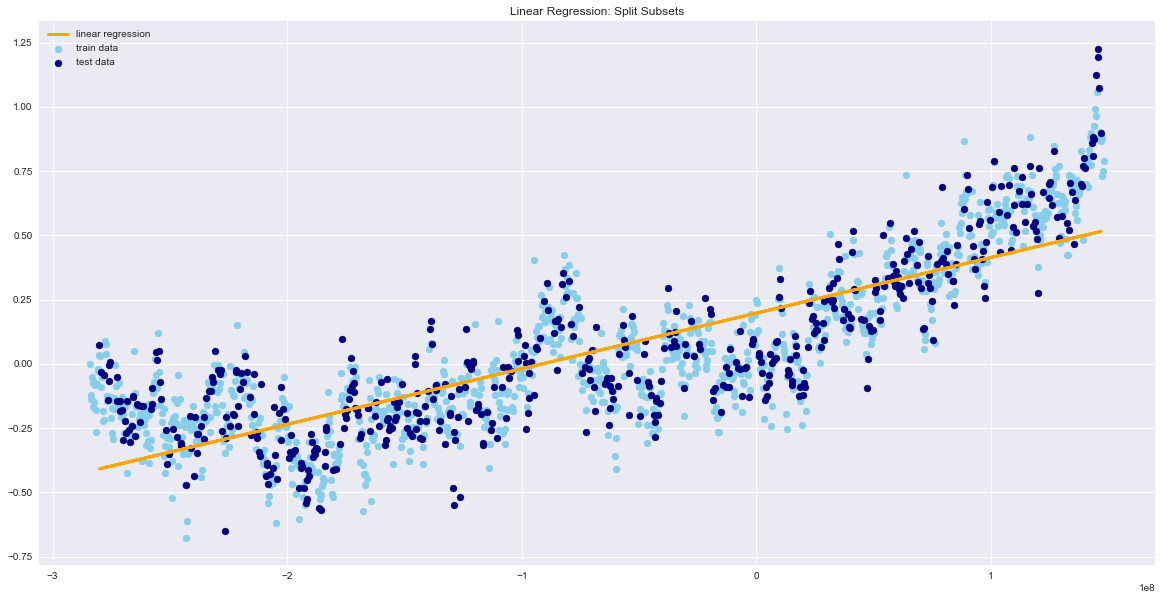

In [25]:
# Plot subsets and prediction 
plt.figure(figsize=(20,10))
plt.scatter(x_train, y_train, color='skyblue', label='train data')
plt.scatter(x_test, y_test, color='navy', label='test data')
plt.plot(x_test, y_prediction, color='orange', linewidth=3, label='linear regression')

plt.axis('tight')
plt.legend()
plt.title("Linear Regression: Split Subsets")

plt.show();